<a href="https://colab.research.google.com/github/Sobhan-Gh/Graph-state-functions/blob/main/LC_equivalence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import numpy as np
import networkx as nx
import random
from itertools import combinations
import warnings
import matplotlib.pyplot as plt


full rank 4 solution basis: True
solution found: 
 [[0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]]


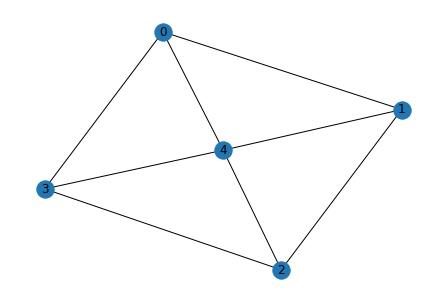

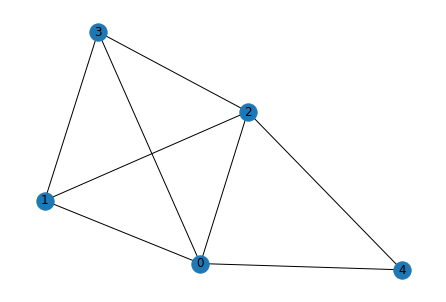

In [209]:
#initialize random graphs for test. n is the number of qubits/ vertices
n=int(5)
row=0
G1, G2 = nx.fast_gnp_random_graph(n,0.65), nx.fast_gnp_random_graph(n,0.65)
#G1=nx.complete_graph(n)
#G2=nx.star_graph(n-1)
if nx.is_connected(G1) and nx.is_connected(G2):
    z_1=nx.to_numpy_array(G1).astype(int)
    z_2=nx.to_numpy_array(G2).astype(int)
else:
    raise ValueError('graphs are not connected')


    #other constraints (Q matrix = local clifford to be reversible --> determinant == 1)     

#takes two adjacency matrices z_1 and z_2 and checks for LC 
#if we got stabilizer states, first turn them to graph and then use this function for their adjacency matrices to check for LC
solution=solver(z_1, z_2, Mode='deter')
plt.figure(1)
nx.draw(G1, with_labels = True)    
plt.figure(2)
nx.draw(G2, with_labels = True)  

In [4]:
def coeff_maker(z_1, z_2):
    row=0
    n=np.shape(z_1)[0]
    assert (np.shape(z_1)[0] == np.shape(z_2)[0]),"graphs must be of same size"

    coeff_matrix=np.zeros((n**2,4*n)).astype(int)
    for j in range(n):
        for k in range(n):
            for m in range(n):
                row = (n*j+k)
                #a_m
                if m == k: 
                  coeff_matrix[row,4*m+0] = z_1[j,k] 
                #b_m
                if (m == k and j == k): 
                  coeff_matrix[row,4*m+1] = 1
                #c_m
                coeff_matrix[row,4*m+2] = z_1[m,j] * z_2[m,k]
                #d_m
                if m == j: 
                  coeff_matrix[row,4*m+3] = z_2[j,k]
    return coeff_matrix%2

In [5]:
#row reduction function
def RowSwap(X,i,j):
  X[[i,j]]=X[[j,i]]
  return X

def Add_Rows(X,i,j):
  X[j]=(X[i]+X[j])%2
  return X
#Returns the row reduced matrix X, the transformed matrix Z and the rank-1
def RowRed(X,Z,pivot):
  n,m=np.shape(X)
  rank=0
  if pivot[1]==(m-1):
    the_ones=[]
    for a in range(pivot[0],n):
      if X[a,pivot[1]]==1:
        the_ones.append(a)
    if not the_ones:
        pivot[0]=pivot[0]-1 #empty under and including pivot on last column 
    else:
        X=RowSwap(X,the_ones[0],pivot[0])
        Z=RowSwap(Z,the_ones[0],pivot[0])
        the_ones.remove(the_ones[0])
        for b in the_ones:
          X=Add_Rows(X,pivot[0],b)
          Z=Add_Rows(Z,pivot[0],b)
    return X,Z,pivot[0]
  elif pivot[0]==(n-1):
    if X[pivot[0],pivot[1]] == 1:
      return X,Z,pivot[0]
    else:
      pivot=[pivot[0],pivot[1]+1]
      X,Z,rank=RowRed(X,Z,pivot)

  else:
    #list of rows with value 1 under the pivot element
    the_ones=[]
    for a in range(pivot[0],n):
      if X[a,pivot[1]]==1:
        the_ones.append(a)
    #check if the column below is empty to skip it
    if not the_ones:
      pivot=[pivot[0],pivot[1]+1]
      X,Z,rank=RowRed(X,Z,pivot)
    else:
      X=RowSwap(X,the_ones[0],pivot[0])
      Z=RowSwap(Z,the_ones[0],pivot[0])
      the_ones.remove(the_ones[0])
      for b in the_ones:
        X=Add_Rows(X,pivot[0],b)
        Z=Add_Rows(Z,pivot[0],b)
      pivot=[pivot[0]+1,pivot[1]+1]
      X,Z,rank=RowRed(X,Z,pivot)
    return X,Z,rank

In [6]:
#find linearly dependent columns in row reduced matrix "x"
#return a list with column indexes
def col_finder(x):
    the_list=[]
    pivot=[0,0]
    m,k=np.shape(x)
    for i in range(k-1):
        #print(pivot)
        if x[pivot[0],pivot[1]] == 1:

            if pivot[0] == (m-1):
                pivot=[pivot[0],pivot[1]+1]
                the_list.extend([* range(pivot[1],k)])
                break
            else:
                pivot=[pivot[0]+1,pivot[1]+1]
            
        elif x[pivot[0],pivot[1]] == 0:
            the_list.append(pivot[1])
            pivot=[pivot[0],pivot[1]+1]
        else:
          raise ValueError('elements of matrix should be 0 or 1 only')
    #if x[-1,-1] == 0: the_list.append(k-1)
    return the_list

In [7]:
def verifier(vector):
    #reshapes a 4*n vector into an array of 2*2 matrices which are the a_i, b_i, c_i, d_i  elements in Q = Clifford matrix 
    n=int(np.shape(vector)[0]/4)
    v=vector.reshape(n,2,2)
    checklist=[]
    for i in range(n):
        a = (v[i][0,0]*v[i][1,1]) + (v[i][0,1]*v[i][1,0]) #XOR
        checklist.append(int(a%2))
    return all(checklist)

In [16]:
def solver(z_1, z_2, Mode='random'):
    n=np.shape(z_1)[0]
    #get the coefficient matrix for the system of linear equations
    coeff_matrix = coeff_maker(z_1, z_2)

    #check for rank to see how many independent equations are there = rank of the matrix
    rank = np.linalg.matrix_rank(coeff_matrix)
    if (rank >= 4*n): 
        print(f'rank = {rank} >= 4n = {4*n} Two graphs/states are not LC equivalent for sure')
        return

    pivot=[0,0]
    reduced_coeff_matrix,b,c=RowRed(coeff_matrix,coeff_matrix*0,pivot) #row redduction applied 
    assert (c+1==rank),f'row reduced rank {c} is not the same as numpy rank {rank}!' 
    if (abs(c-rank)>1): warnings.warn(f'row reduced rank {c} is not the same as numpy rank {rank}!')

    reduced_coeff_matrix=np.array([i for i in reduced_coeff_matrix if i.any()]) #update the matrix to remove zero rows 
    assert (np.shape(reduced_coeff_matrix)[0]==rank),"remaining rows are less than the rank!"
    rank = np.shape(reduced_coeff_matrix)[0]

    col_list = col_finder(reduced_coeff_matrix) #finding linear dependent columns!
    L=len(col_list)
    assert (L==4*n-rank),"column list is not correct"

    #check for random solution 1000 times
    if Mode == 'random':
        rand_s = random_checker(reduced_coeff_matrix, col_list,try_count=1000)
        print(rand_s) #random result

    else:

        #var_vec_list=np.zeros((L,4*n,1)) # L elements and in each element there is a 4*n size vector 
        #for i in range(L):
        #    for j in range(L):
        #        var_vec_list[i,col_list[j]]=basis_list[i][j]

        basis = solution_basis_finder(reduced_coeff_matrix, col_list)
        sub_set = list(combinations(basis, 2))
        solution_set = []
        for x in sub_set:
            a = x[0]+x[1]
            solution_set.append(a%2)
        for y in solution_set:
            if verifier(y):
                print("solution found: \n",y)
                return y
        print("states are NOT LC equivalent")
        return 

def solution_basis_finder(reduced_coeff_matrix, col_list):
    #make the B set: basis for all acceptable solutions
    n=int(np.shape(reduced_coeff_matrix)[1]/4)
    L=len(col_list)
    bbb=[]
    for c in col_list:
      b=reduced_coeff_matrix[:,c]
      b=b.reshape((np.shape(reduced_coeff_matrix)[1]-L,1))
      bbb.append(b)
    B=np.array(bbb) #contains all vectors b as its columns

    A = np.delete(reduced_coeff_matrix,col_list,axis=1) #removing linear dependent columns! 

    X=((np.linalg.inv(A))%2@B)%2
    X=X.astype(int)
    counter=0
    new_X = np.zeros((L,np.shape(reduced_coeff_matrix)[1],1))
    basis_list=np.eye(L).astype(int)
    llist=[]
    for counter in range(L):
        llist.append(list((X[counter][:,0])))
        for i in range(L):
            llist[counter].insert(col_list[i],basis_list[counter,i])
    V=np.array(llist)
    V=V.reshape((L,np.shape(reduced_coeff_matrix)[1],1))

    print(f'full rank {np.shape(V)[0]} solution basis:',np.linalg.matrix_rank(V[:,:,0])==np.shape(V)[0]) # good to be full rank! but it is not necessary actually
    #check also that it give zero array as result:
    assert not(((reduced_coeff_matrix@V)%2).any()),"solution basis is wrong!"
    #L=len(col_list)
    #basis=[]
    #for i in range(L):
    #    basis.append(vec_solution_finder(reduced_coeff_matrix, col_list, var_vec_list[i]))
    return V.astype(int)

def random_checker(reduced_coeff_matrix, col_list,try_count=10000):
    n=int(np.shape(reduced_coeff_matrix)[1]/4)
    L=len(col_list)

    #rand_var_vec = a random choice of the variables' vector for the n-rank parameters that the equations cannot handle!
    
    for i in range(try_count):
        rand_var_vec=np.zeros((4*n,1))
        for i in range(L):
            rand_var_vec[col_list[i]]=np.random.randint(2, size=(1, 1))[0,0]
        solution=vec_solution_finder(reduced_coeff_matrix, col_list, rand_var_vec)
        if verifier(solution):
          print("Random solution found!")
          return solution
    print("Random search unsuccessful")
    return
    


def vec_solution_finder(reduced_coeff_matrix, col_list, var_vec):
    #find the matrix equation Ax=b 
    #A is the square(rank x rank) matrix out of the reduced_coeff_matrix
    #x is the the vector of length=rank to be found by A^(-1)*b
    #b is the vector obtained from randomly choosing the extra unknowns of vector rand_vec: b= (-1)* reduced_coeff_matrix * var_vec

    n=int(np.shape(reduced_coeff_matrix)[1]/4)
    A = np.delete(reduced_coeff_matrix,col_list,axis=1) #removing linear dependent columns! 
    b = (reduced_coeff_matrix @ var_vec)%2
    x = ((np.linalg.inv(A))%2 @ b )%2
    #print(x)

    #the full var_vec is now the x vector inserted to the var_vec vector to make all 4*n elements
    counter=0
    for i in range(4*n):
        if i not in col_list:
            var_vec[i]=x[i-counter][0]
        else:
            counter=counter+1

    return var_vec.astype(int)


In [9]:
coeff_matrix=coeff_maker(z_1, z_2)
np.linalg.matrix_rank(coeff_matrix)
a,b,c=RowRed(coeff_matrix,0*coeff_matrix,[0,0])
#print(a)
all([1,1])
z_2

NameError: ignored

In [ ]:
coeff_matrix = coeff_maker(z_1, z_2)
print(coeff_matrix)

In [ ]:
reduced_coeff_matrix,b,c=RowRed(coeff_matrix,coeff_matrix*0,[0,0])
print(reduced_coeff_matrix,c)

In [ ]:
np.linalg.matrix_rank(coeff_matrix)

In [ ]:
reduced_coeff_matrix=np.array([i for i in reduced_coeff_matrix if i.any()])
print(reduced_coeff_matrix)

In [ ]:
col_list=col_finder(reduced_coeff_matrix)
L=len(col_list)
col_list

In [ ]:
square=np.delete(reduced_coeff_matrix,col_list,axis=1)
square

In [ ]:
#extracting all b vectors from the reduced-coeff-matrix
#***
bbb=[]
for c in col_list:
  b=reduced_coeff_matrix[:,c]
  b=b.reshape((np.shape(reduced_coeff_matrix)[1]-L,1))
  bbb.append(b)

B=np.array(bbb)


In [ ]:
#***
X=((np.linalg.inv(square))%2@B)%2
X=X.astype(int)
counter=0
new_X = np.zeros((L,np.shape(reduced_coeff_matrix)[1],1))
basis_list=np.eye(L).astype(int)
llist=[]
for counter in range(L):
    llist.append(list((X[counter][:,0])))
    for i in range(L):
        llist[counter].insert(col_list[i],basis_list[counter,i])
V=np.array(llist)
V=V.reshape((L,np.shape(reduced_coeff_matrix)[1],1))
#S=V[1]+V[2]
#verifier(S)
print(np.linalg.matrix_rank(V[:,:,0])==np.shape(V)[0]) # good to be full rank! but it is not necessary actually
#check also that it give zero array as result:
print(((reduced_coeff_matrix@V)%2).any())

In [ ]:
basis_set=[v for v in V]
sub_set = list(combinations(basis_set, 2))
solution_set = basis_set #initialize with the basis itself
for x in sub_set:
    a = x[0]+x[1]
    solution_set.append(a%2)
for y in solution_set:
    if verifier(y):
        print("solution found: \n",y)

In [ ]:
basis_set=[v for v in V]

list(combinations(basis_set, 2))[0][0]
print(V[:,:,0].T)
print((((V[:,:,0].T)[:,0])+((V[:,:,0].T)[:,1])+((V[:,:,0].T)[:,2])+((V[:,:,0].T)[:,4])+((V[:,:,0].T)[:,5])+((V[:,:,0].T)[:,3]))%2)

In [ ]:
V[0]

In [ ]:
rand_solution=np.array([[1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [0],
 [1],
 [1],
 [1],
 [0]])
(reduced_coeff_matrix@(rand_solution))%2